# Article Page Views API Example
This example illustrates how to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). This example shows how to request monthly counts of page views for one specific article. The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 14, 2023



In [1]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

The example relies on some constants that help make the code a bit more readable.

In [2]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<uwnetid@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
######## I have changed article titles in a cell below
# ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2023040100"    # this is likely the wrong end date - I changed it 
}


Reading article titles from thank_the_academy.AUG.23.csv

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('thank_the_academy.csv')

In [5]:
ARTICLE_TITLES = df['name'].to_list()

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [6]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [7]:
views_mobile = []
for article_title in ARTICLE_TITLES:
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-app'
    views_mobile_app_article = request_pageviews_per_article(article_title)
    ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-web'
    views_mobile_web_article = request_pageviews_per_article(article_title)
    try:
        res = [{'project': i['project'], 'article': i['article'], 'granularity': i['granularity'], 'timestamp': i['timestamp'], 'views': i['views'] + j['views']} for i, j in zip(views_mobile_app_article['items'], views_mobile_web_article['items'])]
        views_mobile.extend(res)
    except:
        pass

In [8]:
# academy_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json

In [31]:
import csv

keys = views_mobile[0].keys()

with open('csv_files/academy_monthly_mobile_201507-202309.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(views_mobile)

In [32]:
import json
with open('json_files/academy_monthly_mobile_201507-202309.json', 'w') as fout:
    json.dump(views_mobile, fout)

In [11]:
# academy_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json

In [12]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'desktop'
views_desktop = []
for article_title in ARTICLE_TITLES:
    views_desktop_article = request_pageviews_per_article(article_title)
    try:
        # Key to be removed
        key_to_remove = 'access'

        # Remove the specified key from all dictionaries
        list_of_dicts = [{k: v for k, v in d.items() if k != key_to_remove} for d in views_desktop_article['items']]
        
        views_desktop.extend(list_of_dicts)
    except:
        pass

In [33]:
import csv

keys = views_desktop[0].keys()

with open('csv_files/academy_monthly_desktop_201507-202309.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(views_desktop)

In [34]:
import json
with open('json_files/academy_monthly_desktop_201507-202309.json', 'w') as fout:
    json.dump(views_desktop, fout)

In [15]:
# academy_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json

In [16]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'all-access'
views_cumulative = []
for article_title in ARTICLE_TITLES:
    views_cumulative_article = request_pageviews_per_article(article_title)
    try:
        # Key to be removed
        key_to_remove = 'access'

        # Remove the specified key from all dictionaries
        list_of_dicts = [{k: v for k, v in d.items() if k != key_to_remove} for d in views_cumulative_article['items']]
        
        views_cumulative.extend(list_of_dicts)
    except:
        pass

In [35]:
import csv

keys = views_cumulative[0].keys()

with open('csv_files/academy_monthly_cumulative_201507-202309.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(views_cumulative)

In [36]:
import json
with open('json_files/academy_monthly_cumulative_201507-202309.json', 'w') as fout:
    json.dump(views_cumulative, fout)

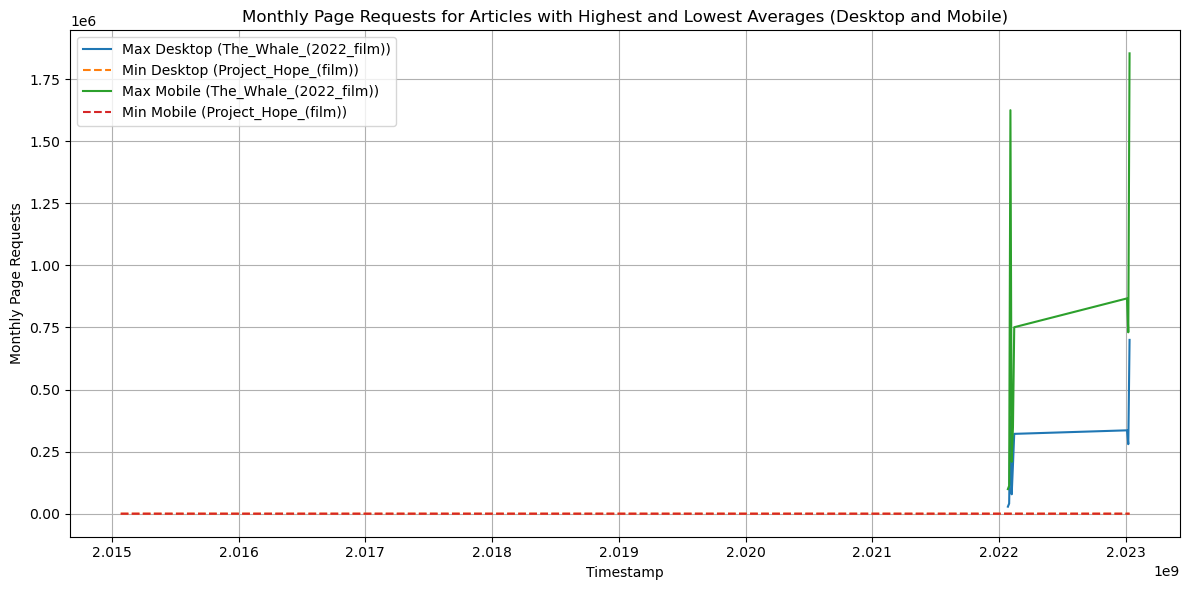

In [37]:
import matplotlib.pyplot as plt

# Load desktop and mobile access data from CSV files
desktop_data = pd.read_csv('academy_monthly_desktop_201507-202309.csv')
mobile_data = pd.read_csv('academy_monthly_mobile_201507-202309.csv')

# Calculate the average monthly page requests for each article
desktop_avg = desktop_data.groupby('article')['views'].mean()
mobile_avg = mobile_data.groupby('article')['views'].mean()

# Find articles with highest and lowest average monthly page requests for desktop and mobile
max_desktop_article = desktop_avg.idxmax()
min_desktop_article = desktop_avg.idxmin()
max_mobile_article = mobile_avg.idxmax()
min_mobile_article = mobile_avg.idxmin()

# Filter the data for these articles
max_desktop_data = desktop_data[desktop_data['article'] == max_desktop_article]
min_desktop_data = desktop_data[desktop_data['article'] == min_desktop_article]
max_mobile_data = mobile_data[mobile_data['article'] == max_mobile_article]
min_mobile_data = mobile_data[mobile_data['article'] == min_mobile_article]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(max_desktop_data['timestamp'], max_desktop_data['views'], label=f'Max Desktop ({max_desktop_article})', linestyle='-')
plt.plot(min_desktop_data['timestamp'], min_desktop_data['views'], label=f'Min Desktop ({min_desktop_article})', linestyle='--')
plt.plot(max_mobile_data['timestamp'], max_mobile_data['views'], label=f'Max Mobile ({max_mobile_article})', linestyle='-')
plt.plot(min_mobile_data['timestamp'], min_mobile_data['views'], label=f'Min Mobile ({min_mobile_article})', linestyle='--')

plt.xlabel('Timestamp')
plt.ylabel('Monthly Page Requests')
plt.title('Monthly Page Requests for Articles with Highest and Lowest Averages (Desktop and Mobile)')
plt.legend()
plt.grid(True)

# Display the plot or save it to a file
plt.tight_layout()
plt.savefig('graphs/1_page_requests_graph.png')
plt.show()

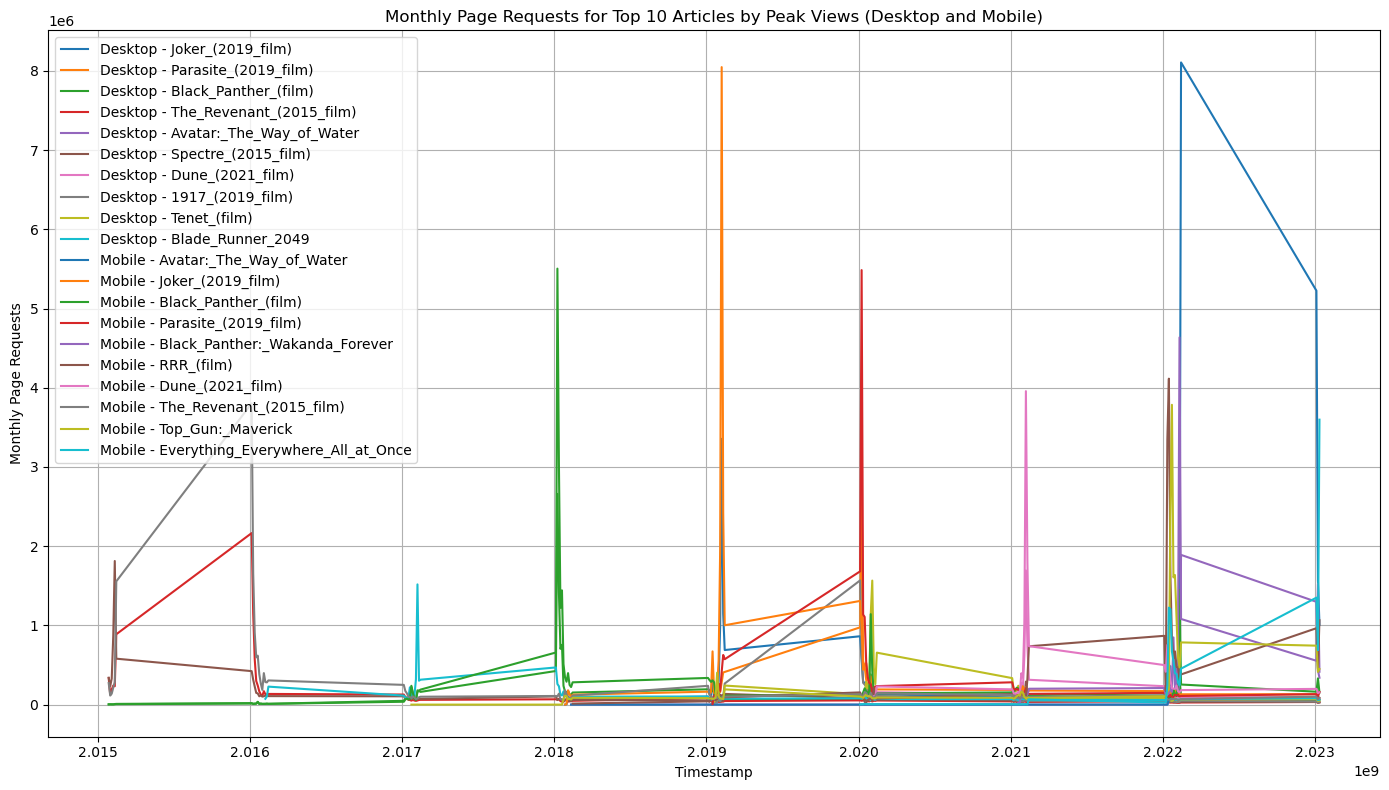

In [38]:
# Find the month with the highest page views for each article
desktop_max_month = desktop_data.groupby('article')['views'].idxmax()
mobile_max_month = mobile_data.groupby('article')['views'].idxmax()

# Get the top 10 articles by peak views for desktop and mobile access
top_desktop_articles = desktop_data.loc[desktop_max_month].nlargest(10, 'views')['article']
top_mobile_articles = mobile_data.loc[mobile_max_month].nlargest(10, 'views')['article']

# Filter the data to include only the top 10 articles by peak views for both desktop and mobile access
filtered_desktop_data = desktop_data[desktop_data['article'].isin(top_desktop_articles)]
filtered_mobile_data = mobile_data[mobile_data['article'].isin(top_mobile_articles)]

# Plot the data with an adjusted figure size
plt.figure(figsize=(14, 8))

# Plot top 10 articles for desktop access
for article in top_desktop_articles:
    data = filtered_desktop_data[filtered_desktop_data['article'] == article]
    plt.plot(data['timestamp'], data['views'], label=f'Desktop - {article}')

# Plot top 10 articles for mobile access
for article in top_mobile_articles:
    data = filtered_mobile_data[filtered_mobile_data['article'] == article]
    plt.plot(data['timestamp'], data['views'], label=f'Mobile - {article}')

plt.xlabel('Timestamp')
plt.ylabel('Monthly Page Requests')
plt.title('Monthly Page Requests for Top 10 Articles by Peak Views (Desktop and Mobile)')
plt.legend()
plt.grid(True)

# Display the plot or save it to a file
plt.tight_layout()
plt.savefig('graphs/2_top_articles_page_views_graph.png')
plt.show()


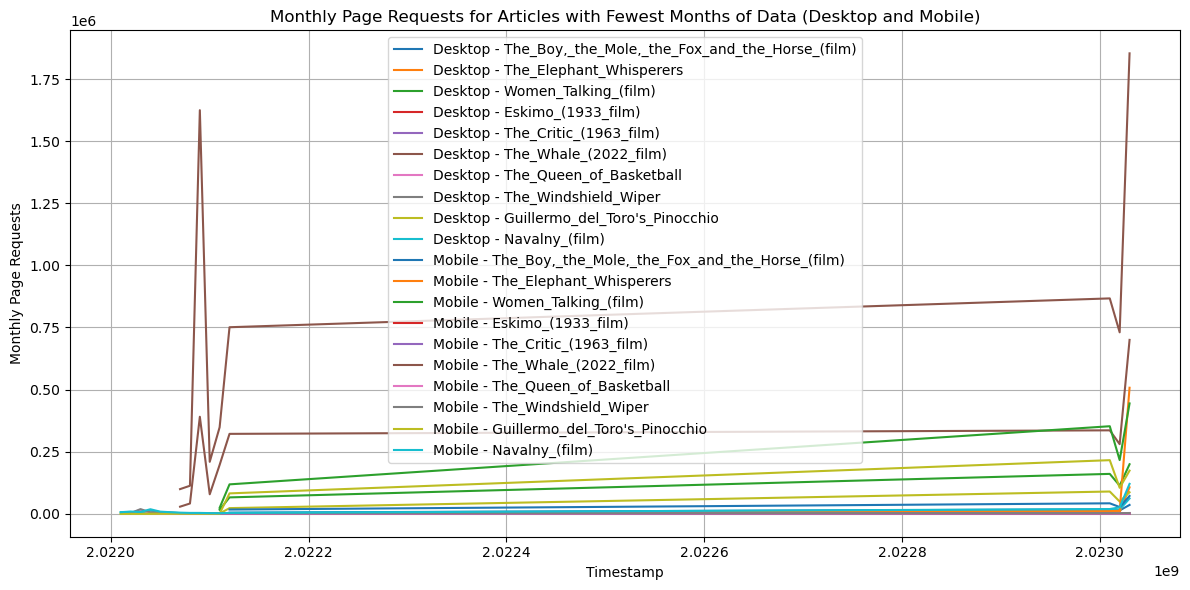

In [39]:
# Calculate the number of unique months of data for each article for desktop and mobile
desktop_months_count = desktop_data.groupby('article')['timestamp'].nunique()
mobile_months_count = mobile_data.groupby('article')['timestamp'].nunique()

# Get the 10 articles with the fewest months of data for desktop and mobile access
top_desktop_articles = desktop_months_count.nsmallest(10).index.tolist()
top_mobile_articles = mobile_months_count.nsmallest(10).index.tolist()

# Filter the data to include only these articles
filtered_desktop_data = desktop_data[desktop_data['article'].isin(top_desktop_articles)]
filtered_mobile_data = mobile_data[mobile_data['article'].isin(top_mobile_articles)]

# Plot the data
plt.figure(figsize=(12, 6))

# Plot data for articles with fewest months of data for desktop access
for article in top_desktop_articles:
    data = filtered_desktop_data[filtered_desktop_data['article'] == article]
    plt.plot(data['timestamp'], data['views'], label=f'Desktop - {article}')

# Plot data for articles with fewest months of data for mobile access
for article in top_mobile_articles:
    data = filtered_mobile_data[filtered_mobile_data['article'] == article]
    plt.plot(data['timestamp'], data['views'], label=f'Mobile - {article}')

plt.xlabel('Timestamp')
plt.ylabel('Monthly Page Requests')
plt.title('Monthly Page Requests for Articles with Fewest Months of Data (Desktop and Mobile)')
plt.legend()
plt.grid(True)

# Display the plot or save it to a file
plt.tight_layout()
plt.savefig('graphs/3_fewest_months_data_graph.png')
plt.show()
